<a href="https://colab.research.google.com/github/Nourjaweny/Some-machine-Learning-projects/blob/main/ABP_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
os.listdir("/content/drive/MyDrive/PFA_1: systeme de prediction de L'ABP/matlabFils")

['part_1.mat',
 'part_2.mat',
 'part_3.mat',
 'part_4.mat',
 'part_5.mat',
 'part_6.mat',
 'part_7.mat',
 'part_8.mat',
 'part_9.mat',
 'part_10.mat',
 'part_11.mat',
 'part_12.mat']

In [ ]:
#Loading a MATLAB File
sample_file = scipy.io.loadmat(f"/content/drive/MyDrive/PFA_1: systeme de prediction de L'ABP/matlabFils/part_1.mat")
#Printing Data Type
print(f'sample_file Data type: {type(sample_file)}')
#Printing Keys
print(f'sample_file keys:\n{sample_file.keys()}')


sample_file Data type: <class 'dict'>
sample_file keys:
dict_keys(['__header__', '__version__', '__globals__', 'p'])


#Data Preprocessing

In [ ]:
# Loading a sample .mat file to understand the data dimensions
test_sample = sample_file['p']
#Printing Data Type
print(f'test_sample Data type: {type(test_sample)}')
#Printing Shape/Dimensions
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [ ]:
#Total samples
print(f"Total Samples: {len(test_sample[0])}")
#Number of eeadings in each sample (column)
print(f"Number of readings in each sample(column): {len(test_sample[0][0])}")
#Number of samples in each reading (ECG)
print(f"Number of samples in each reading(ECG): {len(test_sample[0][0][2])}")

#Accessing a specific sample
temp_mat = test_sample[0, 999]
#Getting the Length of the Sample
temp_length = temp_mat.shape[1]
#Setting the Sample Size
sample_size = 125

#Calculating number of segments
print(temp_length)
#printing temporal length
print((int)(temp_length/sample_size))

Total Samples: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [ ]:
#Setting sample size
sample_size = 125
#Initializing an empty list
ppg = []
#Iterating over samples
for i in range(1000):
  #Extracting segments from each sample
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]
        ppg.append(temp_ppg)

In [ ]:
#Initialization
ecg = []
bp = []
sbp = [] #Systolic Blood Pressure
dbp = [] #Diastolic Blood Pressue
size = 125 #sample size
#Iterating over samples
for i in range(1000):
  #Extracting ECG and BP fata
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ecg = temp_mat[2, j*size:(j+1)*size]
        temp_bp = temp_mat[1, j*size:(j+1)*size]

        #Calculating systolic and diastolic blood pressure
        max_value = max(temp_bp)
        min_value = min(temp_bp)
        sbp.append(max_value)
        dbp.append(min_value)

        #Storing ECG and BP segments
        ecg.append(temp_ecg)
        bp.append(temp_bp)

In [ ]:
# Reshaping the ecg, ppg and bp signal data into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
#Printing the Shapes
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


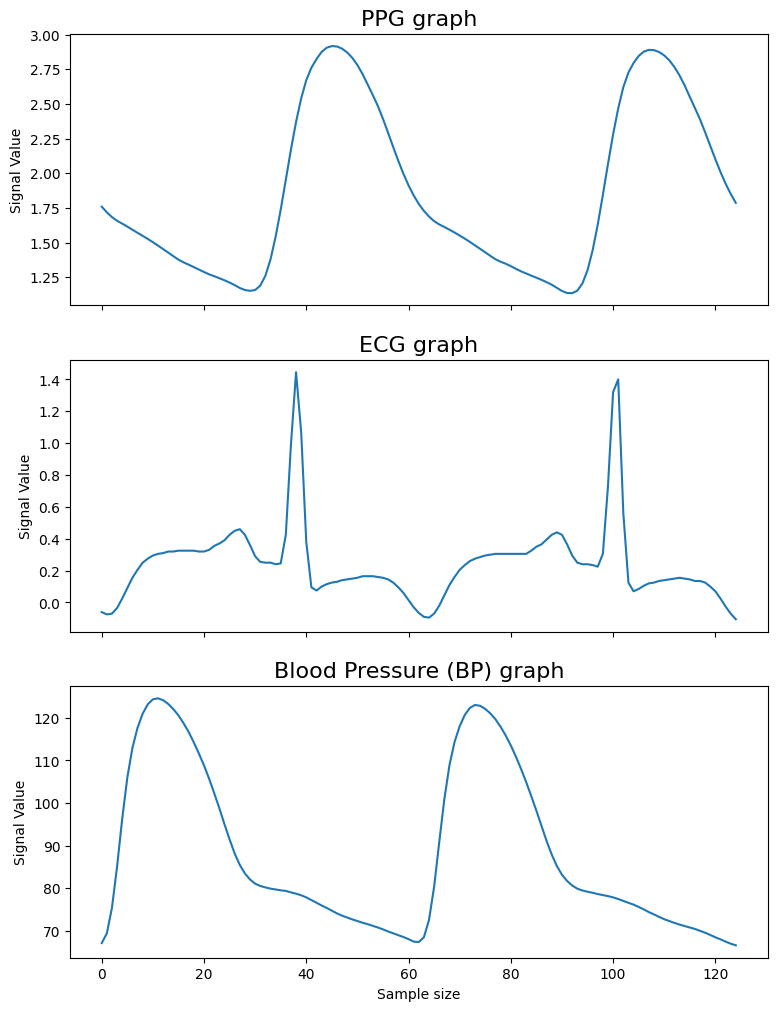

In [ ]:
##plotting sample ppg, ecg and bp signals
##using a sample size of 125
#Creating Subplots
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

#Setting Titles and Labels
ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
#Plotting PPG Signal
ax[0].plot(ppg[:125])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:125])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:125])

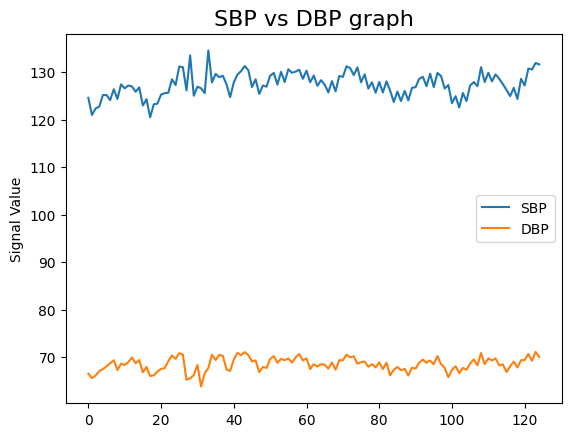

In [ ]:
## Visualizing SBP and DBP
#fig, ax = plt.subplots(1,1, figsize=(9,12))

#Setting up the plot
plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
#Plotting SBP and DBP
plt.plot(sbp[:125])
plt.plot(dbp[:125])
#Adding a legend
plt.legend(['SBP', 'DBP'])

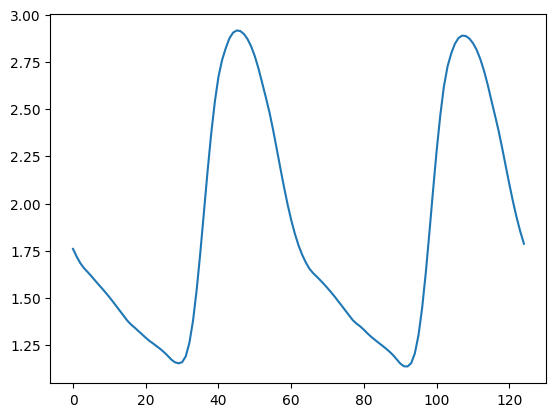

In [ ]:
#Plotting ppg
plt.plot(ppg[:125].squeeze())

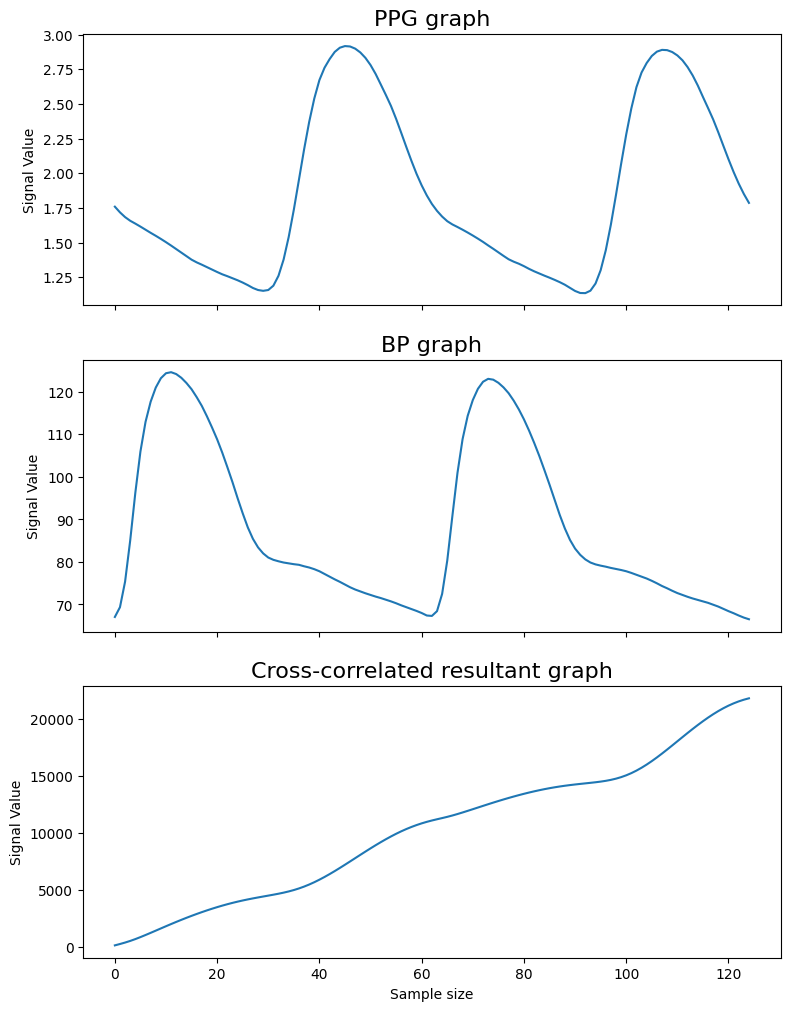

In [ ]:
# Computing the cross correlation of ppg and bp signals
cross_corr = np.convolve(ppg[:125].squeeze(), bp[:125].squeeze(), mode='full')

#Creating Subplots
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

#Plotting PPG and BP Signals
ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('BP graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:125])

#Plotting Cross-correlation Result
ax[2].set_title('Cross-correlated resultant graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(cross_corr[:125])

In [ ]:
# defining our evaluation error function
def rmse(y_true, y_pred):
  #Function Documentation
    """Computes the Root Mean Squared Error (RMSE)."""
    #Calculating RMSE
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
#Computing the discrete cosine transform (DCT)
cosine_transformed_array = dct(ppg)
#Calculating the Root Mean Squared Error (RMSE)
error = rmse(bp.squeeze(), cosine_transformed_array.squeeze())
#Printing the RMSE
print(f'RMSE: {error}')

RMSE: 92.6029607182544


#building The model Using MACHINE LEARNING

Logistic Regression

linear regression model

In [ ]:
#Kfold cross-validation
folds = KFold(n_splits=5, shuffle=False)
scores = []
for i, (train_index, val_index) in enumerate(folds.split(X_train, y_train)):
    train_data, target = X_train[train_index], y_train[train_index]
    validation_data, val_target = X_train[val_index], y_train[val_index]

    model = LinearRegression()
    model.fit(train_data, target)
    #model = RandomForestRegressor(n_estimators=50,max_depth=5, n_jobs=-1, random_state=42)
    #model.fit(train_data[:100000], target[:100000].squeeze())  # training on few samples to save time.
    val_predictions = model.predict(validation_data)
    error = rmse(val_target, val_predictions)
    scores.append(error)
    print(f'Fold {i} RMSE: {error}')
print(f'Average RMSE over 5 folds: {np.mean(scores)}')

Fold 0 RMSE: 27.348391811400155
Fold 1 RMSE: 27.330491324082935
Fold 2 RMSE: 27.33991583796567
Fold 3 RMSE: 27.354251808873396
Fold 4 RMSE: 27.33651113161308
Average RMSE over 5 folds: 27.341912382787047


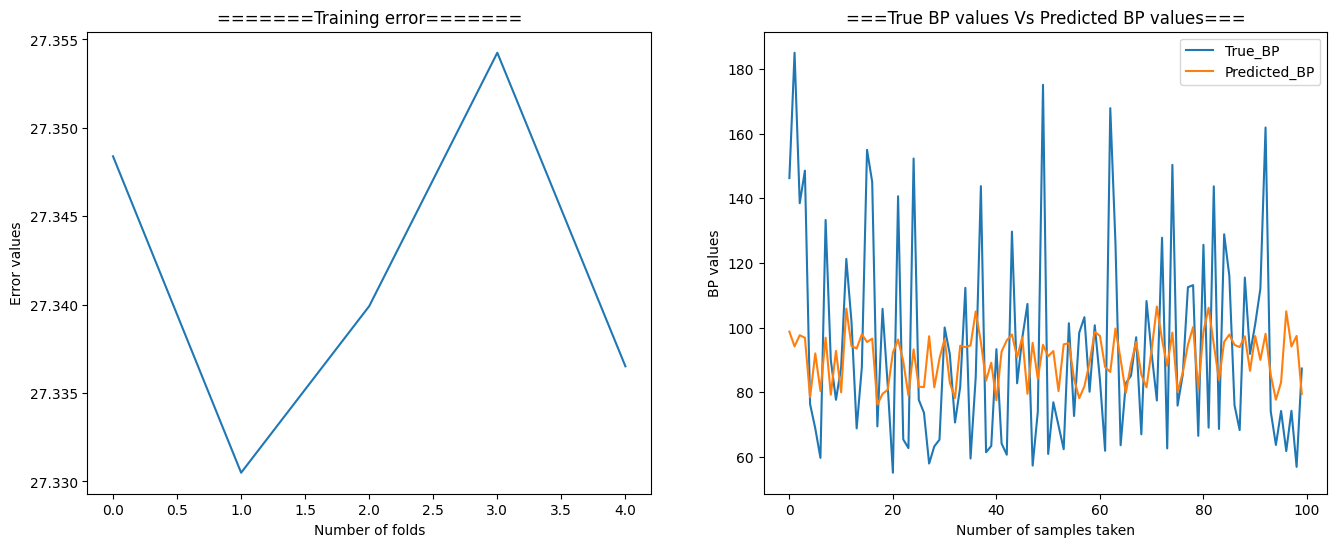

In [ ]:
# Visualizing train error.
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].set_title("=======Training error=======")
ax[0].set_xlabel('Number of folds')
ax[0].set_ylabel('Error values')
ax[0].plot(scores)

# Visualize predicted BP and the True BP
ax[1].set_title("===True BP values Vs Predicted BP values===")
ax[1].set_xlabel('Number of samples taken')
ax[1].set_ylabel('BP values')
ax[1].plot(val_target[:100]) #only plotting 100 samples
ax[1].plot(val_predictions[:100])
ax[1].legend(['True_BP', 'Predicted_BP'])

In [ ]:
# Predicting on the test set
test_predictions = model.predict(X_test[:1000000]) #predicting on the first 1million rows for speed.
test_error = rmse(y_test[:1000000], test_predictions)
print(f'Error on test set predictions: {test_error}')

Error on test set predictions: 27.29914990343146


#Predicting Blood Pressure using Deep Learning

In [ ]:
# Importing TensorFlow library
import tensorflow as tf

# Importing specific layer classes from TensorFlow's Keras API
# Fully connected layer
from tensorflow.keras.layers import Dense
# Batch normalization layer
from tensorflow.keras.layers import BatchNormalization
# Activation function layer
from tensorflow.keras.layers import Activation
# Dropout layer
from tensorflow.keras.layers import Dropout
# Sequential model for linear stack of layers
from tensorflow.keras.models import Sequential
# Optimizers for training the neural network
from tensorflow.keras import optimizers


In [ ]:
def Model(input_dim, activation, num_class):
    model = Sequential()

    model.add(Dense(1024, input_dim = input_dim))
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation(activation))
    model.add(Dropout(0.25))

    model.add(Dense(num_class))
    model.add(Activation('linear'))

    model.compile(loss='Huber',
                  optimizer=optimizers.Adam(lr = 0.001),
                  metrics=['MeanAbsoluteError']
                 )
    return model

In [ ]:
input_dim = X_train.shape[1]
activation = 'relu'
classes = 1
model = Model(input_dim=input_dim, activation=activation, num_class=classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              2048      
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                3

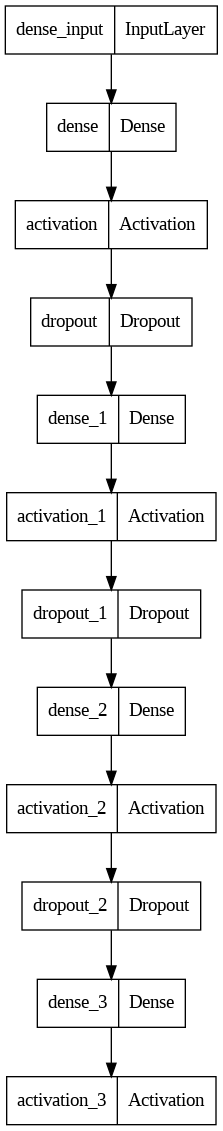

In [ ]:
# Visualizing the model
tf.keras.utils.plot_model(model)

In [ ]:
# Training the model
history = model.fit(X_train[:1000000], # using the first 1million rows for speed.
                    y_train[:1000000].squeeze(),
                    epochs=5,
                    batch_size=128,
                    verbose = 1
                   )

Epoch 1/5
7813/7813 [==============================] - 199s 25ms/step - loss: 22.6809 - mean_absolute_error: 23.1759
Epoch 2/5
7813/7813 [==============================] - 177s 23ms/step - loss: 21.0421 - mean_absolute_error: 21.5366
Epoch 3/5
7813/7813 [==============================] - 176s 22ms/step - loss: 20.7186 - mean_absolute_error: 21.2131
Epoch 4/5
7813/7813 [==============================] - 177s 23ms/step - loss: 20.5724 - mean_absolute_error: 21.0668
Epoch 5/5
7813/7813 [==============================] - 178s 23ms/step - loss: 20.4288 - mean_absolute_error: 20.9231


In [ ]:
#Predicting on the test set using the nn(neural network) model
nn_predictions = model.predict(X_test[:1000000])
error = rmse(y_test[:1000000], nn_predictions)
print(f'Neural Net RMSE: {error}')

In [ ]:
plt.title('Train loss against mean_absolute_error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Loss', 'Mean_absolute_error'])

In [ ]:
# Visualize predicted BP and the True BP
plt.title("===True BP values Vs Predicted BP values===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test[:100]) #only plotting 100 samples
plt.plot(nn_predictions[:100])
plt.legend(['True_BP', 'Predicted_BP'])

In [ ]:
#end of the project